In [1]:
from PIL import Image
import numpy as np
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from os import listdir
from numpy import savez_compressed
from os.path import isdir
from keras.models import load_model
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [9]:
# extract a single face from a given photograph
def extract_face(filename, required_size = (160,160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    print(type(results), len(results))
    x1,y1,width,height = results[0]['box']
    #bug fix
    x1,y1 = abs(x1), abs(y1)
    x2,y2 = x1 + width, y1+height
    face = pixels[y1:y2, x1:x2]
    type(face)
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    for filename in listdir(directory):
        path = directory + filename
        face = extract_face(path)
        #store
        faces.append(face)
    return faces


# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X,y = list(), list()
    for subdir in listdir(directory):
        #path
        path = directory + subdir + '/'
        #skip any files that might be in the dir
        if not isdir(path):
            continue
        faces = load_faces(path)
        #create label
        labels = [subdir for _ in range(len(faces))]
        print('>loaded %d examples for class: %s' %(len(faces), subdir))
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [10]:
# folder = '5-celebrity-faces-dataset/train/ben_afflek/'
# i = 1
# for filename in listdir(folder):
#     path = folder + filename
#     face = extract_face(path)
#     print(i, face.shape)
#     plt.subplot(2,7,i)
#     plt.axis('off')
#     plt.imshow(face)
#     i += 1
# plt.show()

In [17]:
a = extract_face('/home/labib/Work/face_pipe/5-celebrity-faces-dataset/ben_afflek/httptrwebimgacstanetcxbdddmediasnmediajpg.jpg')
a.shape

<class 'list'> 1


(160, 160, 3)

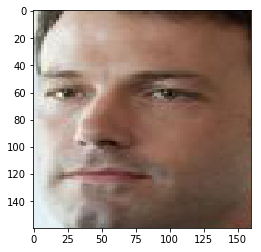

In [18]:
plt.imshow(a)

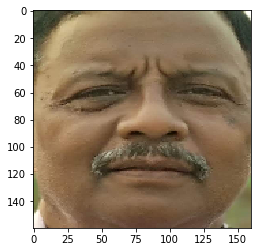

In [33]:
f = '/home/labib/Work/face_pipe/5-celebrity-faces-dataset/train/Baba/IMG_20181017_165719.jpg'
image = Image.open(f)
image = image.convert('RGB') 
pixels = np.asarray(image)
detector = MTCNN()
results = detector.detect_faces(pixels)
#pixels = np.asarray(results)
x1,y1,width,height = results[0]['box']
#bug fix
x1,y1 = abs(x1), abs(y1)
x2,y2 = x1 + width, y1+height
face = pixels[y1:y2, x1:x2]
type(face)
image = Image.fromarray(face)
image = image.resize((160,160))
face_array = np.asarray(image)
face_array.shape
plt.imshow(face_array)

In [12]:
trainx, trainy = load_dataset('5-celebrity-faces-dataset/train/Baba/')
print(trainx.shape, trainy.shape)

# testx, testy = load_dataset('5-celebrity-faces-dataset/val/')
# print(testx.shape, testy.shape)

(0,) (0,)


mindy_kaling


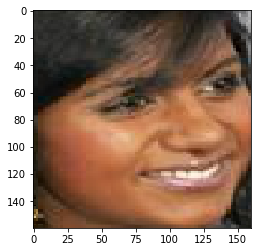

In [5]:
n = 52
plt.imshow(trainx[n])
print(trainy[n])

In [6]:
#savez_compressed('5-celebrity-faces-dataset.npz', trainx, trainy, testx,testy)

In [7]:
from numpy import expand_dims

def get_embedding(model, face_pixels):
    
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = expand_dims(face_pixels, axis = 0)
    #get embedding
    y0 = model.predict(samples)
#     print(y0.shape)
#     print(y0)
    return y0[0]

In [9]:
model = load_model("./model/facenet_keras.h5")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________________
Conv2d_2a_

/home/labib/anaconda3/envs/labib/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
#find emb and store in a numpy 
embtrainx = list()
for face_pixels in trainx:
    emb = get_embedding(model, face_pixels)
    embtrainx.append(emb)
embtrainx = np.asarray(embtrainx)
# embtestx = list()
# for face_pixels in testx:
#     emb = get_embdding(model, face_pixels)
#     embtestx.append(emb)
# embtestx = np.asarray(embtestx)

# embtrainx.shape, embtestx.shape


## inference 

In [11]:
def distance(e1,e_org):
    return np.sum(np.square(e1 - e_org))

In [24]:
def inference(model, inf, embtrainx,trainy):
    inf_emb = get_embedding(model, inf)
    min_distance = 1000
    dist = []
    for i in range(embtrainx.shape[0]):
        dis = distance(inf_emb, embtrainx[i])
        dist.append(dis)
        if dis < min_distance and dis != 0.0:
            min_distance = dis
            who = trainy[i]
    if min_distance > 100:
        #embtrainx.append(inf_emb)
        print("This is a new person!")
        embtrainx = embtrainx.tolist()
        embtrainx.append(inf_emb)
        embtrainx = np.asarray(embtrainx)
        name = input('Enter the name of the person: ')
        trainy = trainy.tolist()
        trainy.append(name)
        trainy = np.asarray(trainy)
        print("Added!")
    else:
        print("Predicted identity: %s , distance: %d " %(who , min_distance))
        
    return embtrainx, trainy
        
    
    

Original Identity: jerry_seinfeld
Predicted identity: jerry_seinfeld , distance: 50 
(92, 128) (92,)


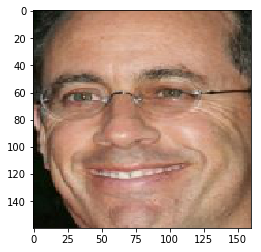

In [25]:
#test
n = 5
inf = testx[n]
plt.imshow(inf)
print("Original Identity: %s" %testy[n])#true identity
embtrainx , trainy = inference(model, inf, embtrainx, trainy)
print(embtrainx.shape, trainy.shape)

In [44]:
# #test on new image
# embtrainx , trainy = inference(model, x_nbm, embtrainx, trainy)
# embtrainx.shape, trainy.shape

nbm 75.36394720678527


((93, 128), (93,))

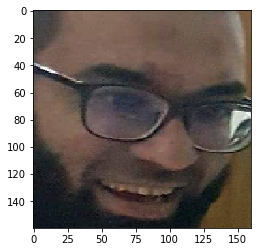

In [28]:
#introducing new person
f = './nbm2.jpg'

x_new = extract_face(f)

plt.imshow(x_new)

In [30]:
embtrainx, trainy = inference(model, x_new, embtrainx,trainy)

This is a new person!


Enter the name of the person:  nbm


Added!


In [31]:
embtrainx.shape

(93, 128)

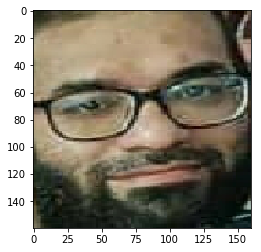

In [32]:
#check whether new person added or not
f = './nbm/nbm1.jpg'

x_new = extract_face(f)

plt.imshow(x_new)

In [33]:
embtrainx, trainy = inference(model, x_new, embtrainx,trainy)

Predicted identity: nbm , distance: 75 


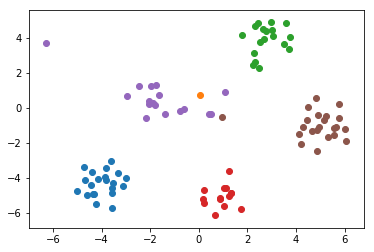

In [34]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embtrainx)

for i, t in enumerate(set(trainy)):
    idx = trainy == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

In [35]:
print('Done!')

Done!
